In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy.io as sio
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations

%matplotlib inline


In [2]:
def logistic(x, min_val, max_val, k=1):
    x0 = (min_val+max_val)/2
    return 1/(1 + np.exp(-k*(x-x0)))
#     return np.exp(x0+ k*x)/(1 + np.exp(x0+ k*x))

In [3]:
def heart_data():
    data = pd.read_csv('data/processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_data():
    data = pd.read_csv('data/wine.data', header=None)
    
    cols = list(data.columns)
    target = data[cols[0]].copy()
    data[cols[0]] = data[cols[-1]]
    data[cols[-1]] = target
    
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def wine_quality():
#     data = pd.read_csv('data/winequality-red.csv', sep=';')
    data = pd.read_csv('data/winequality-white.csv', sep=';')
    cols = list(data.columns)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_adult():
    data = pd.read_csv('data/adult.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

def load_abalone():
    data = pd.read_csv('data/abalone.data', header=None)
    cat_columns = data.select_dtypes(['object']).columns
    for c in cat_columns:
        data[c] = data[c].astype('category')
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    cols = list(data.columns)
    
    data = data.groupby(cols[-1]).filter(lambda x: len(x) > 2)
    data[cols[-1]] -= min(data[cols[-1]])
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data
    

def load_mat(mat_file):
    data = sio.loadmat(mat_file)
    data = np.concatenate((data['X'], data['Y']-1), axis=1)
#     plt.scatter(data[:300,0], data[:300,1], c='c', marker='x')
#     plt.scatter(data[300:600,0], data[300:600,1], c='b', marker='x')
#     plt.scatter(data[900:1200,0], data[900:1200,1], c='g', marker='x')
#     plt.scatter(data[600:900,0], data[600:900,1], c='r', marker='x')
#     plt.scatter(data[1200:1500,0], data[1200:1500,1], c='y', marker='x')
#     plt.scatter(data[1500:1800,0], data[1500:1800,1], c='m', marker='x')
#     plt.scatter(data[1800:2100,0], data[1800:2100,1], c='k', marker='x')
#     plt.scatter(data[2100:2400,0], data[2100:2400,1], marker='x')
#     plt.show()
    data = pd.DataFrame(data=data)
    return data


In [4]:
def synthetic_data(p, t, n_dim=2):
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    
    q0 = p*t
    q1 = p*(t-q0)
    q2 = p*(t-q0-q1)
    q3 = p*(t-q0-q1-q2)
    q4 = t-q0-q1-q2-q3
    
    q = [np.int(q0), np.int(q1), np.int(q2), np.int(q3), np.int(q4)]
    
#     mean0 = np.ones(n_dim)*1
#     mean1 = np.ones(n_dim)*1.5
#     mean2 = np.ones(n_dim)*1.7
#     mean3 = np.ones(n_dim)*0.5
#     mean4 = np.ones(n_dim)*1.65
    
    
    mean0 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean1 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean2 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean3 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    mean4 = np.random.randint(1,3, size=n_dim)*np.random.rand(n_dim)
    
    
#     np.random.seed(1234)
    
    var0 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var1 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var2 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var3 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    var4 = np.diag(np.random.randint(1,10, size=n_dim)*np.random.rand(n_dim))
    
    #g0 = np.random.multivariate_normal(mean0, np.eye(13), size=q[0])
    #g1 = np.random.multivariate_normal(mean1, np.eye(13), size=q[1])
    #g2 = np.random.multivariate_normal(mean2, np.eye(13), size=q[2])
    #g3 = np.random.multivariate_normal(mean3, np.eye(13), size=q[3])
    #g4 = np.random.multivariate_normal(mean4, np.eye(13), size=q[4])
    
    g0 = np.random.multivariate_normal(mean0, var0, size=q[0])
    g1 = np.random.multivariate_normal(mean1, var1, size=q[1])
    g2 = np.random.multivariate_normal(mean2, var2, size=q[2])
    g3 = np.random.multivariate_normal(mean3, var3, size=q[3])
    g4 = np.random.multivariate_normal(mean4, var4, size=q[4])

    
    y0 = np.asarray([0]*q[0]).reshape(q[0],1)
    y1 = np.asarray([1]*q[1]).reshape(q[1],1)
    y2 = np.asarray([2]*q[2]).reshape(q[2],1)
    y3 = np.asarray([3]*q[3]).reshape(q[3],1)
    y4 = np.asarray([4]*q[4]).reshape(q[4],1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)
    d = pd.DataFrame(data=g)

#     d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    if n_dim == 2:
        plt.scatter(g0[:,0], g0[:,1], c='c')
        plt.scatter(g1[:,0], g1[:,1], c='b')
        plt.scatter(g2[:,0], g2[:,1], c='r')
        plt.scatter(g3[:,0], g3[:,1], c='g')
        plt.scatter(g4[:,0], g4[:,1], c='y')
        plt.show()
    elif n_dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(g0[:,0], g0[:,1], g0[:,2], c='c')
        ax.scatter(g1[:,0], g1[:,1], g1[:,2], c='b')
        ax.scatter(g2[:,0], g2[:,1], g2[:,2], c='r')
        ax.scatter(g3[:,0], g3[:,1], g3[:,2], c='g')
        ax.scatter(g4[:,0], g4[:,1], g4[:,2], c='y')
        plt.show()
    
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])


In [76]:
class ClassifierWithRoc(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_classes = len(np.unique(Y))
        self.n_clf = self.n_classes * (self.n_classes - 1) // 2
        self.c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,self.n_classes)),2))]
    
    def split_data(self, X, Y, min_samples=500):
        if X.shape[0] >= min_samples:
            x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X, Y, test_size=.40, stratify=Y)
            x_val, x_test, y_val, y_test = train_test_split(x_test_and_val, y_test_and_val, 
                                                            test_size=.50, stratify=y_test_and_val)
        else:
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.20, stratify=Y)
            x_val = None; y_val = None
            
        return x_train, x_val, x_test, y_train, y_val, y_test
    
    def z_score(self, x_train):      
        scaler = preprocessing.StandardScaler().fit(x_train)
        return scaler
    
    def estimator(self, x_train, y_train, scaler):
        x_train = scaler.transform(x_train)
        ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), n_jobs=-1)
        ovo.fit(x_train, y_train)
        return ovo
    
    def predict(self, estimator, x_test, y_test, scaler, points=None, c=0, mode='half'):
        modes = {'zero': 0, 'half': 0.5, 'one':1}
        x_test = scaler.transform(x_test)
        if points is None:
            pred = estimator.predict(x_test)
            cm = confusion_matrix(y_test, pred)
            acc = cm.diagonal().sum() / cm.sum()
            return [pred, cm, acc]
        elif c < 2:
            y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
            votes = np.zeros(y_test_bin.shape)
            for i in range(self.n_clf):
                clf = estimator.estimators_[i]
                proba = clf.decision_function(x_test)
                for j, p in enumerate(proba):
                    if p > points[i][c] or np.isclose(p,points[i][c]):
                        votes[j, self.c_groups[i][0]] += 1
                    else:
                        votes[j, self.c_groups[i][1]] += 1
        elif c == 2:
            if mode != 'logistic':
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i].max() or np.isclose(p, points[i].max()):
                            votes[j, self.c_groups[i][0]] += 1
                        elif p > points[i].min() and p < points[i].max():
                            votes[j, self.c_groups[i][0]] += modes[mode]
                            votes[j, self.c_groups[i][1]] += modes[mode]
                        elif p < points[i].min():
                            votes[j, self.c_groups[i][1]] += 1
            else:
                y_test_bin = label_binarize(y_test, classes=list(range(self.n_classes)))
                votes = np.zeros(y_test_bin.shape)
                for i in range(self.n_clf):
                    clf = estimator.estimators_[i]
                    proba = clf.decision_function(x_test)
                    for j, p in enumerate(proba):
                        if p > points[i].max() or np.isclose(p, points[i].max()):
                            votes[j, self.c_groups[i][0]] += 1
                        elif p > points[i].min() and p < points[i].max():
                            #adjust steepness to interval
                            #12 seeems to be a good number
                            k = 12 / (abs(max(points[i]) - min(points[i])))
                            point = logistic(p, min(points[i]), max(points[i]), k=k)
                            votes[j, self.c_groups[i][0]] += point
                            votes[j, self.c_groups[i][1]] += 1-point
                        elif p < points[i].min():
                            votes[j, self.c_groups[i][1]] += 1
        
        occurrences = np.asarray([np.where(t==t.max())[0] for t in votes])
        pred = [p[-1] for p in occurrences]
        cm = confusion_matrix(y_test, pred)
        acc = cm.diagonal().sum() / cm.sum()
        return [pred, cm, acc]
        
        
    def calculate_roc(self, estimator, x_val, x_train, y_val, y_train, scaler):
        clf_index = 0
        fpr = dict(); tpr = dict(); thresholds = dict(); roc_auc = dict(); cutpoints = dict()
        x_val = scaler.transform(x_val) if x_val is not None else None
        x_train = scaler.transform(x_train)
        y_val_bin = label_binarize(y_val, classes=list(range(self.n_classes))) if y_val is not None else None
        y_train_bin = label_binarize(y_train, classes=list(range(self.n_classes)))
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                if j > i:
                    clf = estimator.estimators_[clf_index]
                    if y_val_bin is not None and x_val is not None:
                        proba = clf.decision_function(x_val)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_val_bin[:, i]-1),
                                                                                          proba)
                    else:
                        proba = clf.decision_function(x_train)
                        fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(y_train_bin[:, i]-1),
                                                                                          proba)
                    roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
                    youden_cut = youden_index(fpr[clf_index], tpr[clf_index])
                    maxdor_cut = max_dor(fpr[clf_index], tpr[clf_index])
                    y_index = np.where(np.isclose(fpr[clf_index],youden_cut[0]))[0][0]
                    d_index = np.where(np.isclose(fpr[clf_index],maxdor_cut[0]))[0][0]
                    if y_index == 0:
                        y_index += 1
                    if d_index == 0:
                        d_index += 1

                    cutpoints[clf_index] = np.array([thresholds[clf_index][y_index], thresholds[clf_index][d_index]])
                    clf_index += 1
        return fpr, tpr, thresholds, roc_auc, cutpoints
    
    def plot_roc(self, fpr, tpr, thresholds, roc_auc, cutpoints, show=True, save=False):
        for i in range(self.n_clf):
            youden_cut = youden_index(fpr[i], tpr[i])
            maxdor_cut = max_dor(fpr[i], tpr[i])
            fig, ax = plt.subplots(1,2, figsize=(15,7))
            lw = 2
            ax[0].plot(fpr[i], tpr[i], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
            ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
            ax[0].set_xlim([-0.05, 1.05])
            ax[0].set_ylim([-0.05, 1.05])
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')
            ax[0].set_title('Receiver operating characteristic for class ' + str(tuple(reversed(self.c_groups[i]))))
            #ax.scatter(opt_cutpoint1[0], opt_cutpoint1[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
            #ax.scatter(opt_cutpoint2[0], opt_cutpoint2[1], c='r', zorder=1, label='MaxSe cutpoint', s=50)
            ax[0].scatter(youden_cut[0], youden_cut[1], c='b', zorder=1, label='Youden', s=50)
            ax[0].scatter(maxdor_cut[0], maxdor_cut[1], c='r', zorder=1, label='Max Dor', s=50)
            ax[0].legend(loc="lower right")

            ax2 = ax[0].twinx()
            ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
            ax2.set_ylabel('Threshold',color='r')
            ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
            ax2.set_xlim([-0.05, 1.05])

            if np.isclose(min(cutpoints[i]), max(cutpoints[i])):  
                ax[1].axis('off')
            else:
                #adjust steepness to interval
                #12 seeems to be a good number
                k = 12 / (abs(max(cutpoints[i]) - min(cutpoints[i])))

                x_range = np.arange(min(cutpoints[i]), max(cutpoints[i]), 0.0001)
                y_range = logistic(x_range, min(cutpoints[i]), max(cutpoints[i]), k=k)
                ax[1].set_title('Logistic function between cutpoints')

                ax[1].spines['left'].set_position('center')
                ax[1].spines['right'].set_color('none')
                ax[1].spines['top'].set_color('none')
                ax[1].xaxis.set_ticks_position('bottom')
                ax[1].yaxis.set_ticks_position('left')
                ax[1].plot(x_range, y_range, c='y', lw=lw, zorder=-1)
                ax[1].scatter(cutpoints[i][0], logistic(cutpoints[i][0], min(cutpoints[i]), max(cutpoints[i]), k=k), 
                              c='b', zorder=1, label='Youden', s=50)
                ax[1].scatter(cutpoints[i][1], logistic(cutpoints[i][1], min(cutpoints[i]), max(cutpoints[i]), k=k),
                              c='r', zorder=1, label='Max Dor', s=50)

                ax[1].plot([x_range[0], x_range[0]], [-0.05, y_range[0]], linestyle='--', c='k')
                ax[1].plot([x_range[-1], x_range[-1]], [-0.05, y_range[-1]], linestyle='--', c='k')
                ax[1].set_xticks(cutpoints[i], minor=False)

            
            fig.subplots_adjust(hspace=0.3, wspace=0.6, top=0.8)
            if save:
                plots_folder = os.path.join(os.getcwd(),'roc_plots')
                if not os.path.exists(plots_folder):
                    os.mkdir(plots_folder)
                plt.savefig(os.path.join(os.getcwd(), 'heart_' + str(tuple(reversed(self.c_groups[i])))) + '.png',
                            bbox_inches='tight', pad_inches=0.5)
            if show:
                plt.show()
        
        
        

In [73]:
def apply(data, times=1):
    cols = list(data.columns)
    Y = data[cols[-1]].copy()
    cols.remove(cols[-1])
    X = data[cols].copy()
    roc_clf = ClassifierWithRoc(X,Y)
    
    pred = []; pred_y = []; pred_dor = []; pred_zero = []; pred_half = []; pred_one = []; pred_log = []
    
    for i in range(times):
        x_train, x_val, x_test, y_train, y_val, y_test = roc_clf.split_data(X, Y, min_samples=250)
        scaler = roc_clf.z_score(x_train)
        est = roc_clf.estimator(x_train, y_train, scaler)
        fpr, tpr, thresholds, roc_auc, cutpoints = roc_clf.calculate_roc(est, x_val, x_train, y_val, 
                                                                         y_train, scaler)
        pred.append(roc_clf.predict(est, x_test, y_test, scaler))
        pred_y.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=0))
        pred_dor.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=1))
        pred_zero.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='zero'))
        pred_half.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='half'))
        pred_one.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='one'))
        pred_log.append(roc_clf.predict(est, x_test, y_test, scaler, cutpoints, c=2, mode='logistic'))
        roc_clf.plot_roc(fpr, tpr, thresholds, roc_auc, cutpoints)
    
    pred = np.asarray(pred); pred_y = np.asarray(pred_y); pred_dor = np.asarray(pred_dor); 
    pred_zero = np.asarray(pred_zero); pred_half = np.asarray(pred_half); pred_one = np.asarray(pred_one); 
    pred_log = np.asarray(pred_log)
    
    print(np.mean(pred[:,2]))
    print(np.mean(pred_y[:,2]))
    print(np.mean(pred_dor[:,2]))
    print(np.mean(pred_zero[:,2]))
    print(np.mean(pred_half[:,2]))
    print(np.mean(pred_one[:,2]))
    print(np.mean(pred_log[:,2]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


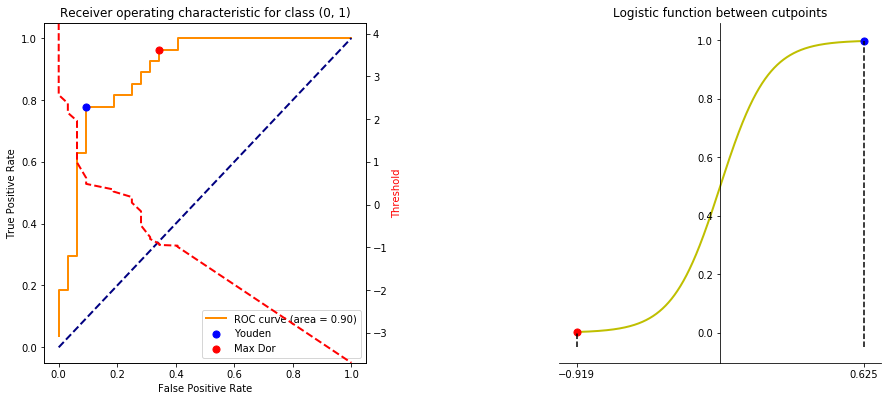

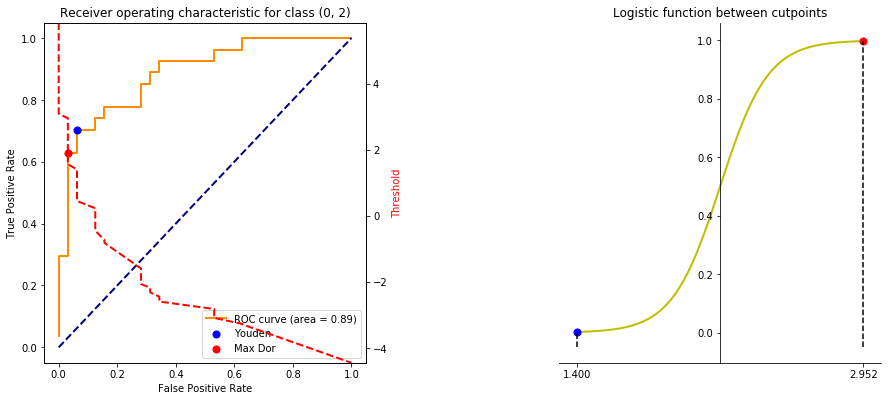

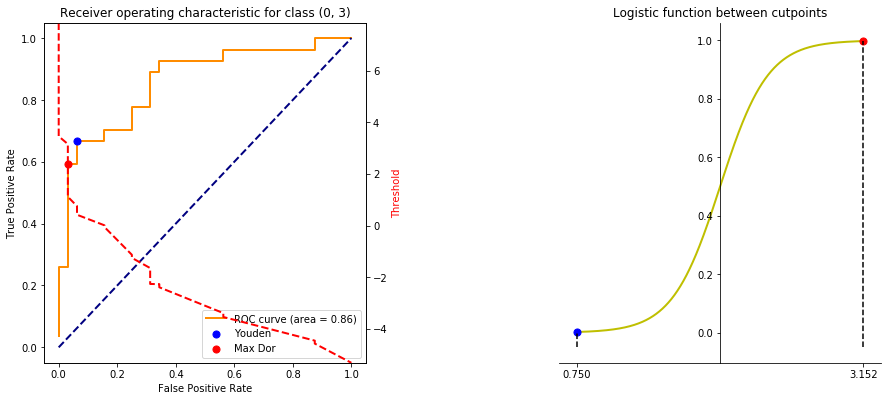

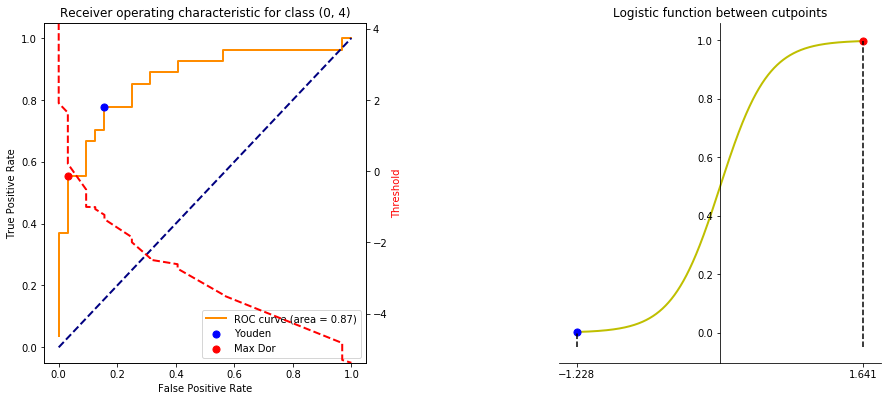

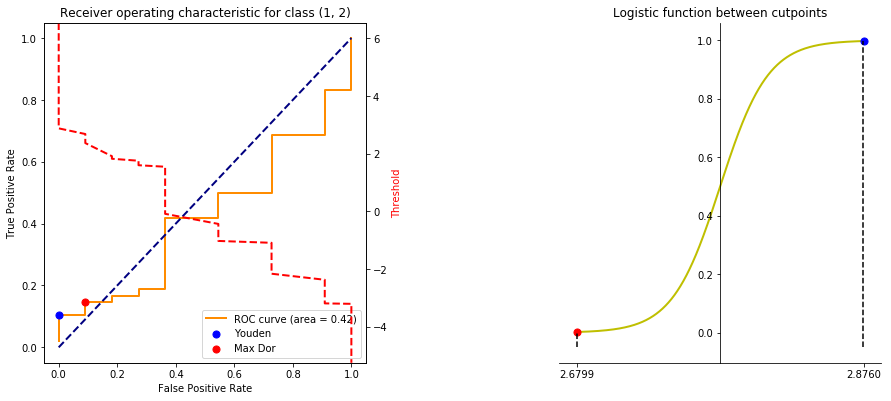

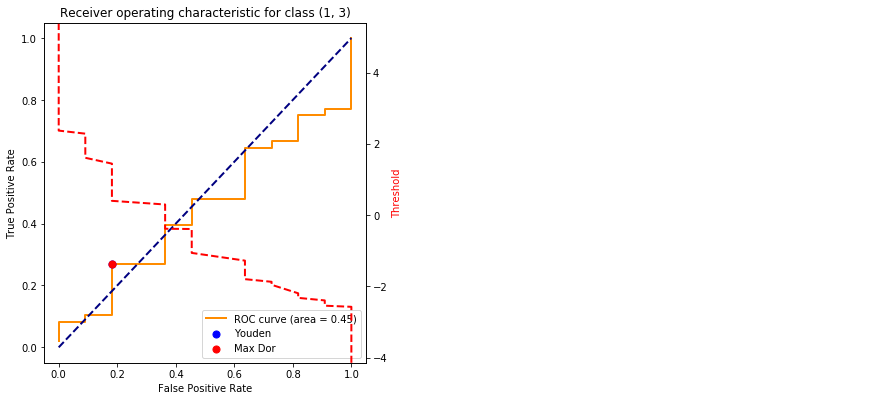

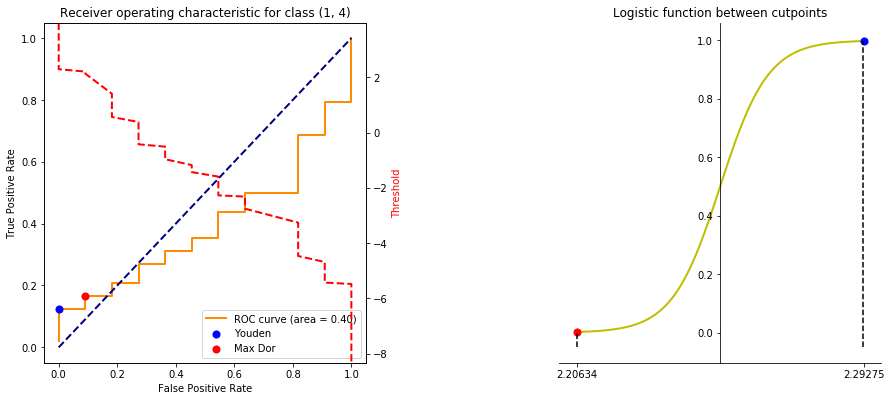

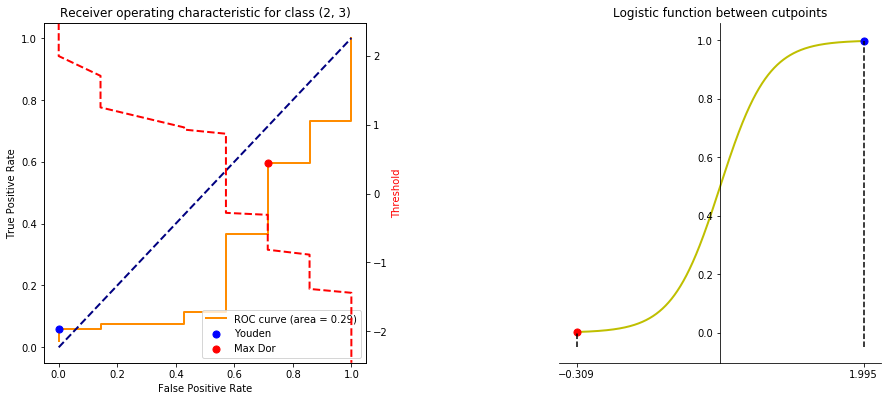

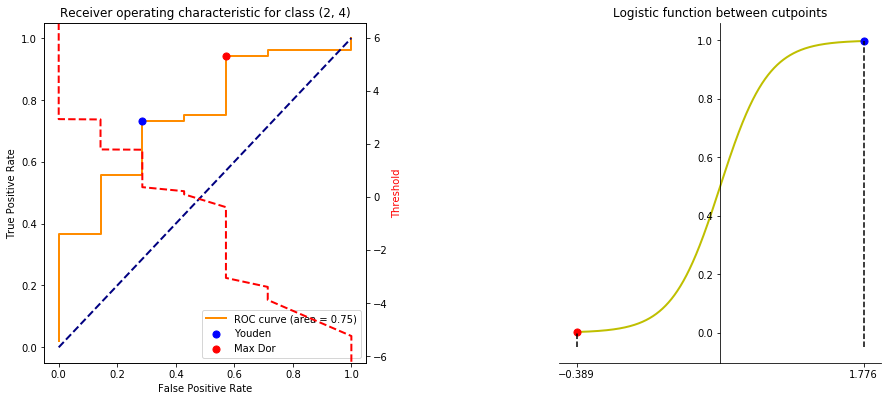

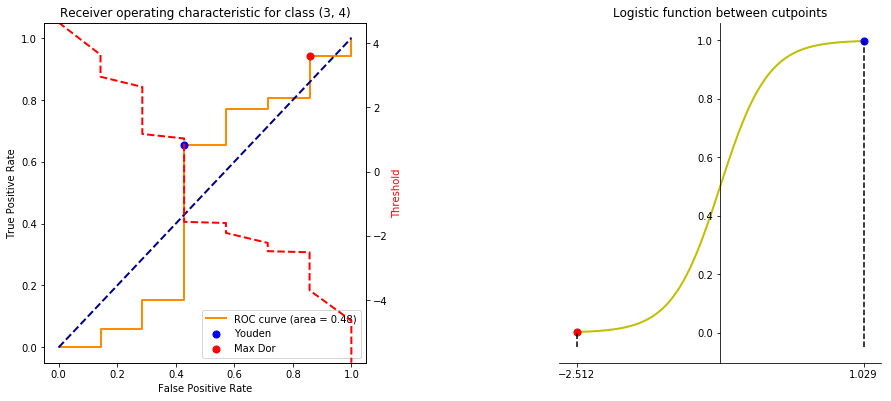

0.5
0.55
0.583333333333
0.55
0.566666666667
0.616666666667
0.533333333333


In [77]:
data = heart_data()
apply(data)

In [64]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]-1
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                
## https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
def max_dor(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt_dor = -1
    for i in range(len(fpr)):
        dor = (se[i]/(1.0-se[i]))*(sp[i]/(1.0-sp[i]))
        if dor > opt_dor and not np.isinf(dor) and not np.isnan(dor):
            opt_dor = dor
            index = i
    return fpr[index], tpr[index]
